In [1]:
import numpy as np
import os
from glob import glob
import cv2

from keras.layers import Input, Dense, Reshape, Flatten, Dropout
from keras.layers import BatchNormalization, Activation, ZeroPadding2D, UpSampling2D, Conv2D
from keras.layers.advanced_activations import LeakyReLU
from keras.models import Sequential, Model
from keras.optimizers import Adam

%matplotlib inline
import matplotlib.pyplot as plt

Using TensorFlow backend.
C:\machine_study\Python\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [21]:
#PATH = os.path.abspath(os.path.join('..','input', 'flowers', 'flowers', 'rose'))
PATH = os.path.abspath(os.path.join('data','flowers', 'rose'))
IMGS = glob(os.path.join(PATH, "*.jpg"))

print(len(IMGS)) # number of the rose images
print(IMGS[:10]) # rose images filenames

784
['F:\\Kaggle\\generateSP\\data\\flowers\\rose\\10090824183_d02c613f10_m.jpg', 'F:\\Kaggle\\generateSP\\data\\flowers\\rose\\102501987_3cdb8e5394_n.jpg', 'F:\\Kaggle\\generateSP\\data\\flowers\\rose\\10503217854_e66a804309.jpg', 'F:\\Kaggle\\generateSP\\data\\flowers\\rose\\10894627425_ec76bbc757_n.jpg', 'F:\\Kaggle\\generateSP\\data\\flowers\\rose\\110472418_87b6a3aa98_m.jpg', 'F:\\Kaggle\\generateSP\\data\\flowers\\rose\\11102341464_508d558dfc_n.jpg', 'F:\\Kaggle\\generateSP\\data\\flowers\\rose\\11233672494_d8bf0a3dbf_n.jpg', 'F:\\Kaggle\\generateSP\\data\\flowers\\rose\\11694025703_9a906fedc1_n.jpg', 'F:\\Kaggle\\generateSP\\data\\flowers\\rose\\118974357_0faa23cce9_n.jpg', 'F:\\Kaggle\\generateSP\\data\\flowers\\rose\\11944957684_2cc806276e.jpg']


In [22]:
WIDTH = 28
HEIGHT = 28
DEPTH = 3

In [23]:
def procImages(images):
    processed_images = []
    
    # set depth
    depth = None
    if DEPTH == 1:
        depth = cv2.IMREAD_GRAYSCALE
    elif DEPTH == 3:
        depth = cv2.IMREAD_COLOR
    else:
        print('DEPTH must be set to 1 or to 3.')
        return None
    
    #resize images
    for img in images:
        base = os.path.basename(img)
        full_size_image = cv2.imread(img, depth)
        processed_images.append(cv2.resize(full_size_image, (WIDTH, HEIGHT), interpolation=cv2.INTER_CUBIC))
    processed_images = np.asarray(processed_images)
    
    # rescale images to [-1, 1]
    processed_images = np.divide(processed_images, 127.5) - 1

    return processed_images

In [24]:
processed_images = procImages(IMGS[:38])
processed_images.shape

(38, 28, 28, 3)

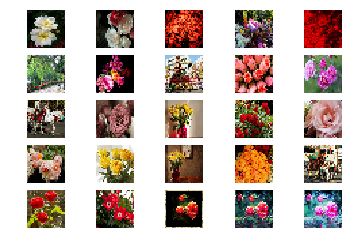

In [25]:
fig, axs = plt.subplots(5, 5)
count = 0
for i in range(5):
    for j in range(5):
        img = processed_images[count, :, :, :] * 127.5 + 127.5
        img = np.asarray(img, dtype=np.uint8)
        if DEPTH == 3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        axs[i, j].imshow(img)
        axs[i, j].axis('off')
        count += 1
plt.show()

In [26]:
# GAN parameters
LATENT_DIM = 100
G_LAYERS_DIM = [256, 512, 1024]
D_LAYERS_DIM = [1024, 512, 256]

BATCH_SIZE = 8
EPOCHS = 1000
LR = 0.0002
BETA_1 = 0.5

In [27]:
def buildGenerator(img_shape):

    def addLayer(model, dim):
        model.add(Dense(dim))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))
        
    model = Sequential()
    model.add(Dense(G_LAYERS_DIM[0], input_dim=LATENT_DIM))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization(momentum=0.8))
    
    for layer_dim in G_LAYERS_DIM[1:]:
        addLayer(model, layer_dim)
        
    model.add(Dense(np.prod(img_shape), activation='tanh'))
    model.add(Reshape(img_shape))

    model.summary()

    noise = Input(shape=(LATENT_DIM,))
    img = model(noise)

    return Model(noise, img)

In [28]:
#g = buildGenerator(processed_images.shape[1:])

In [29]:
def buildDiscriminator(img_shape):

    def addLayer(model, dim):
        model.add(Dense(dim))
        model.add(LeakyReLU(alpha=0.2))

    model = Sequential()
    model.add(Flatten(input_shape=img_shape))
    
    for layer_dim in D_LAYERS_DIM:
        addLayer(model, layer_dim)
        
    model.add(Dense(1, activation='sigmoid'))
    model.summary()

    img = Input(shape=img_shape)
    classification = model(img)

    return Model(img, classification)

In [30]:
#d = buildDiscriminator(processed_images.shape[1:])

In [31]:
def buildCombined(g, d):
    # fix d for training g in the combined model
    d.trainable = False

    # g gets z as input and outputs fake_img
    z = Input(shape=(LATENT_DIM,))
    fake_img = g(z)

    # gets the classification of the fake image
    gan_output = d(fake_img)

    # the combined model for training generator g to fool discriminator d
    model = Model(z, gan_output)
    model.summary()
    
    return model

In [32]:
def sampleImages(generator):
    rows, columns = 5, 5
    noise = np.random.normal(0, 1, (rows * columns, LATENT_DIM))
    generated_imgs = generator.predict(noise)

    fig, axs = plt.subplots(rows, columns)
    count = 0
    for i in range(rows):
        for j in range(columns):
            img = generated_imgs[count, :, :, :] * 127.5 + 127.5
            img = np.asarray(img, dtype=np.uint8)
            if DEPTH == 3:
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axs[i, j].imshow(img)
            axs[i, j].axis('off')
            count += 1
    plt.show()

In [33]:
#sampleImages(g)

In [34]:
#instantiate the optimizer
optimizer = Adam(LR, BETA_1)

In [35]:
#build the discriminator
d = buildDiscriminator(processed_images.shape[1:])
d.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_2 (Flatten)          (None, 2352)              0         
_________________________________________________________________
dense_9 (Dense)              (None, 1024)              2409472   
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 1024)              0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               524800    
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 512)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_9 (LeakyReLU)    (None, 256)               0         
__________

In [36]:
#build generator
g = buildGenerator(processed_images.shape[1:])
g.compile(loss='binary_crossentropy', optimizer=optimizer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 256)               25856     
_________________________________________________________________
leaky_re_lu_10 (LeakyReLU)   (None, 256)               0         
_________________________________________________________________
batch_normalization_4 (Batch (None, 256)               1024      
_________________________________________________________________
dense_14 (Dense)             (None, 512)               131584    
_________________________________________________________________
leaky_re_lu_11 (LeakyReLU)   (None, 512)               0         
_________________________________________________________________
batch_normalization_5 (Batch (None, 512)               2048      
_________________________________________________________________
dense_15 (Dense)             (None, 1024)              525312    
__________

In [37]:
#build combined model
c = buildCombined(g, d)
c.compile(loss='binary_crossentropy', optimizer=optimizer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_5 (Model)              (None, 28, 28, 3)         3100720   
_________________________________________________________________
model_4 (Model)              (None, 1)                 3065857   
Total params: 6,166,577
Trainable params: 3,097,136
Non-trainable params: 3,069,441
_________________________________________________________________


0 [Discriminator Loss: 0.735960, Acc.: 37.50%] [Generator Loss: 0.563058]


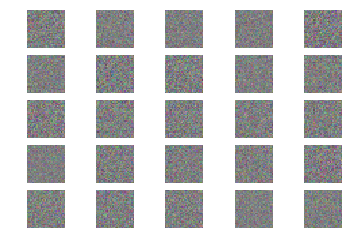

99 [Discriminator Loss: 0.212139, Acc.: 50.00%] [Generator Loss: 5.619397]


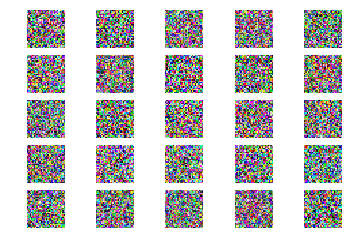

199 [Discriminator Loss: 0.236047, Acc.: 50.00%] [Generator Loss: 2.438845]


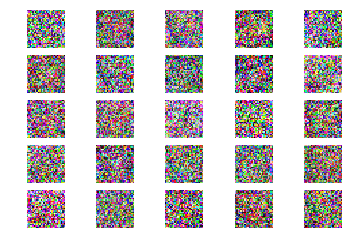

299 [Discriminator Loss: 0.383425, Acc.: 50.00%] [Generator Loss: 2.876804]


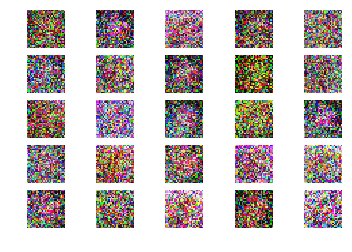

399 [Discriminator Loss: 0.277170, Acc.: 43.75%] [Generator Loss: 3.776616]


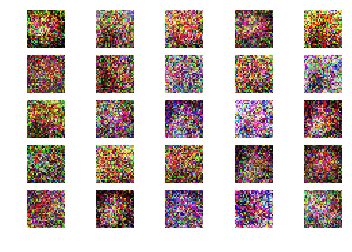

499 [Discriminator Loss: 0.394908, Acc.: 43.75%] [Generator Loss: 6.558036]


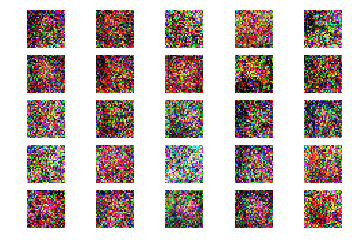

599 [Discriminator Loss: 0.276782, Acc.: 50.00%] [Generator Loss: 1.931533]


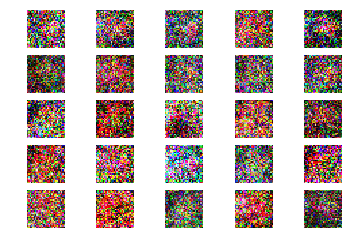

699 [Discriminator Loss: 0.337168, Acc.: 50.00%] [Generator Loss: 1.696914]


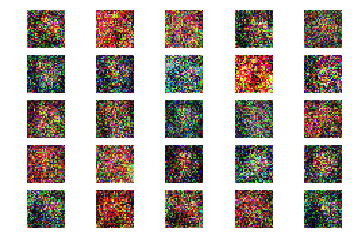

799 [Discriminator Loss: 0.363094, Acc.: 50.00%] [Generator Loss: 1.895038]


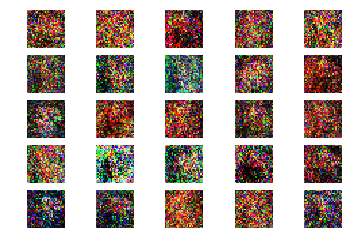

899 [Discriminator Loss: 0.236125, Acc.: 50.00%] [Generator Loss: 3.826627]


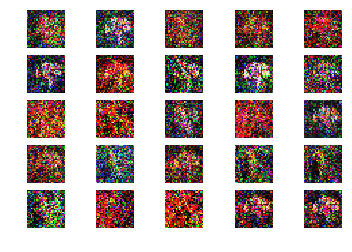

999 [Discriminator Loss: 0.333370, Acc.: 50.00%] [Generator Loss: 3.722838]


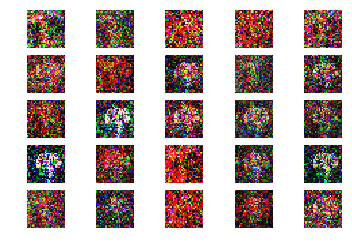

In [38]:
#training
SAMPLE_INTERVAL = WARNING_INTERVAL = 100

YDis = np.zeros(2 * BATCH_SIZE)
YDis[:BATCH_SIZE] = .9 #Label smoothing

YGen = np.ones(BATCH_SIZE)

for epoch in range(EPOCHS):
    # get a batch of real images
    idx = np.random.randint(0, processed_images.shape[0], BATCH_SIZE)
    real_imgs = processed_images[idx]

    # generate a batch of fake images
    noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
    fake_imgs = g.predict(noise)
    
    X = np.concatenate([real_imgs, fake_imgs])
    
    # Train discriminator
    d.trainable = True
    d_loss = d.train_on_batch(X, YDis)

    # Train the generator
    d.trainable = False
    #noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
    g_loss = c.train_on_batch(noise, YGen)

    # Progress
    if (epoch+1) % WARNING_INTERVAL == 0 or epoch == 0:
        print ("%d [Discriminator Loss: %f, Acc.: %.2f%%] [Generator Loss: %f]" % (epoch, d_loss[0], 100. * d_loss[1], g_loss))

    # If at save interval => save generated image samples
    if (epoch+1) % SAMPLE_INTERVAL == 0 or epoch == 0:
        sampleImages(g)

In [39]:
def buildGeneratorDC(img_shape):
    model = Sequential()

    model.add(Dense(128 * 7 * 7, activation="relu", input_dim=LATENT_DIM))
    model.add(Reshape((7, 7, 128)))
    model.add(UpSampling2D())
    model.add(Conv2D(128, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(64, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Conv2D(DEPTH, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    model.summary()

    noise = Input(shape=(LATENT_DIM,))
    img = model(noise)

    return Model(noise, img)

In [40]:
def buildDiscriminatorDC(img_shape):
    model = Sequential()

    model.add(Conv2D(32, kernel_size=3, strides=2, input_shape=img_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    
    model.add(Conv2D(64, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dropout(0.25))
    model.add(Conv2D(128, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dropout(0.25))
    model.add(Conv2D(256, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1, activation='sigmoid'))

    model.summary()

    img = Input(shape=img_shape)
    classification = model(img)

    return Model(img, classification)

In [41]:
#build the discriminator
dDC = buildDiscriminatorDC(processed_images.shape[1:])
dDC.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 14, 14, 32)        896       
_________________________________________________________________
leaky_re_lu_13 (LeakyReLU)   (None, 14, 14, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 64)          18496     
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 8, 8, 64)          0         
_________________________________________________________________
batch_normalization_7 (Batch (None, 8, 8, 64)          256       
_________________________________________________________________
leaky_re_lu_14 (LeakyReLU)   (None, 8, 8, 64)          0         
__________

In [42]:
#build generator
gDC = buildGeneratorDC(processed_images.shape[1:])
gDC.compile(loss='binary_crossentropy', optimizer=optimizer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_18 (Dense)             (None, 6272)              633472    
_________________________________________________________________
reshape_3 (Reshape)          (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d_1 (UpSampling2 (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 14, 128)       147584    
_________________________________________________________________
batch_normalization_10 (Batc (None, 14, 14, 128)       512       
_________________________________________________________________
activation_1 (Activation)    (None, 14, 14, 128)       0         
_________________________________________________________________
up_sampling2d_2 (UpSampling2 (None, 28, 28, 128)       0         
__________

In [43]:
#build combined model
cDC = buildCombined(gDC, dDC)
cDC.compile(loss='binary_crossentropy', optimizer=optimizer)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_9 (InputLayer)         (None, 100)               0         
_________________________________________________________________
model_8 (Model)              (None, 28, 28, 3)         857347    
_________________________________________________________________
model_7 (Model)              (None, 1)                 394305    
Total params: 1,251,652
Trainable params: 856,963
Non-trainable params: 394,689
_________________________________________________________________


0 [Discriminator Loss: 0.838134, Acc.: 6.25%] [Generator Loss: 0.195116]


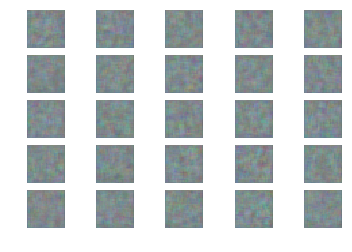

99 [Discriminator Loss: 0.451329, Acc.: 50.00%] [Generator Loss: 1.412469]


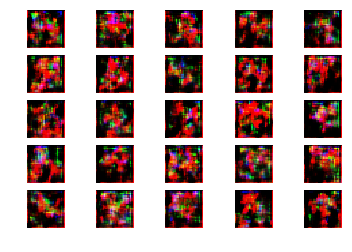

199 [Discriminator Loss: 0.648800, Acc.: 43.75%] [Generator Loss: 1.512884]


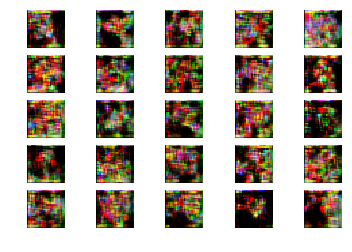

299 [Discriminator Loss: 0.327334, Acc.: 50.00%] [Generator Loss: 1.721663]


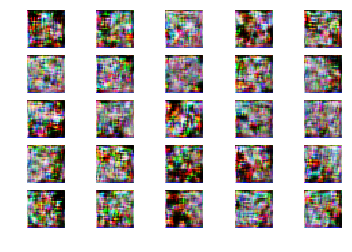

399 [Discriminator Loss: 0.225179, Acc.: 50.00%] [Generator Loss: 1.260699]


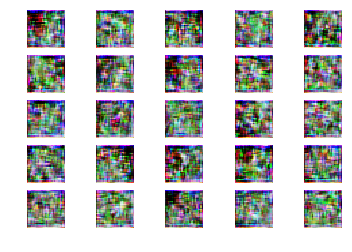

499 [Discriminator Loss: 0.182530, Acc.: 50.00%] [Generator Loss: 1.080065]


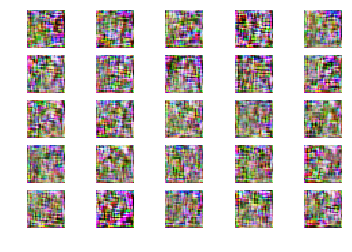

599 [Discriminator Loss: 0.189010, Acc.: 50.00%] [Generator Loss: 0.609959]


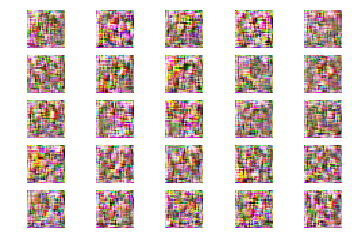

699 [Discriminator Loss: 0.180463, Acc.: 50.00%] [Generator Loss: 0.590156]


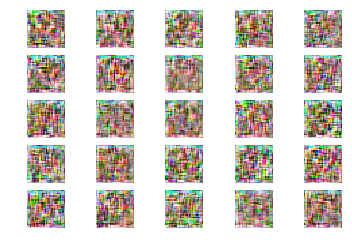

799 [Discriminator Loss: 0.199331, Acc.: 50.00%] [Generator Loss: 0.908572]


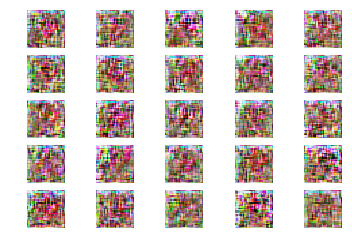

899 [Discriminator Loss: 0.173646, Acc.: 50.00%] [Generator Loss: 0.468359]


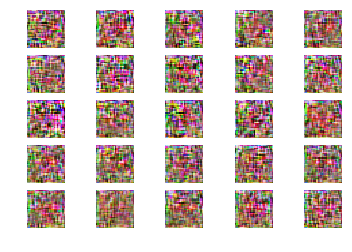

999 [Discriminator Loss: 0.191003, Acc.: 50.00%] [Generator Loss: 0.783292]


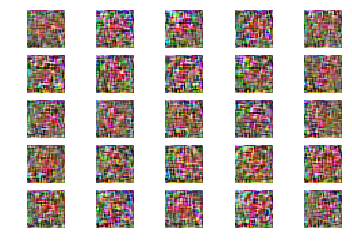

In [45]:
#training DC GAN
SAMPLE_INTERVAL = WARNING_INTERVAL = 100

YDis = np.zeros(2 * BATCH_SIZE)
YDis[:BATCH_SIZE] = .9 #Label smoothing

YGen = np.ones(BATCH_SIZE)

for epoch in range(EPOCHS):
    # get a batch of real images
    idx = np.random.randint(0, processed_images.shape[0], BATCH_SIZE)
    real_imgs = processed_images[idx]

    # generate a batch of fake images
    noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
    fake_imgs = gDC.predict(noise)
    
    X = np.concatenate([real_imgs, fake_imgs])
    
    # Train discriminator
    dDC.trainable = True
    d_loss = dDC.train_on_batch(X, YDis)

    # Train the generator
    dDC.trainable = False
    #noise = np.random.normal(0, 1, (BATCH_SIZE, LATENT_DIM))
    g_loss = cDC.train_on_batch(noise, YGen)

    # Progress
    if (epoch+1) % WARNING_INTERVAL == 0 or epoch == 0:
        print ("%d [Discriminator Loss: %f, Acc.: %.2f%%] [Generator Loss: %f]" % (epoch, d_loss[0], 100. * d_loss[1], g_loss))

    # If at save interval => save generated image samples
    if (epoch+1) % SAMPLE_INTERVAL == 0 or epoch == 0:
        sampleImages(gDC)